In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# **IMPORTS**

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import lightgbm as lgb

In [3]:
# sample_sub_df = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

In [4]:
# path_submission = '/kaggle/input/Cinema-Audience-Forecasting-challenge/sample_submission/sample_submission.csv'


# df = pd.read_csv(path_submission)

# date_strings = df['ID'].str.split('_').str[-1]
# dates = pd.to_datetime(date_strings)
# earliest_date = dates.min()
# latest_date = dates.max()

# start_date_str = earliest_date.strftime('%d-%m-%Y')
# end_date_str = latest_date.strftime('%d-%m-%Y')
# print(f"Date range for sample_submission: \"{start_date_str} to {end_date_str}\"")

In [5]:
# submission_df = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")
# submission_df['audience_count'] = mean_audience
# submission_df.to_csv('submission.csv', index=False)

In [6]:
booknow_visits = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
booknow_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")
booknow_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")

cinePOS_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")
cinePOS_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")

movie_theater_id_relation = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")
date_info = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")
sample_sub = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

# **EDA** 

In [7]:
dfs = [
    (booknow_visits, 'booknow_visits'),
    (booknow_booking, 'booknow_booking'),
    (booknow_theaters, 'booknow_theaters'),
    (cinePOS_booking, 'cinePOS_booking'),
    (cinePOS_theaters, 'cinePOS_theaters'),
    (movie_theater_id_relation, 'movie_theater_id_relation'),
    (date_info, 'date_info'),
]
for df, name in dfs:
    print(f'{name}: shape={df.shape}, columns={list(df.columns)}')

booknow_visits: shape=(214046, 3), columns=['book_theater_id', 'show_date', 'audience_count']
booknow_booking: shape=(68336, 4), columns=['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked']
booknow_theaters: shape=(829, 5), columns=['book_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']
cinePOS_booking: shape=(1641966, 4), columns=['cine_theater_id', 'show_datetime', 'booking_datetime', 'tickets_sold']
cinePOS_theaters: shape=(4690, 5), columns=['cine_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']
movie_theater_id_relation: shape=(150, 2), columns=['book_theater_id', 'cine_theater_id']
date_info: shape=(547, 2), columns=['show_date', 'day_of_week']


In [8]:
for df, name in dfs:
    print(f'\n{name} info:')
    print(df.info())


booknow_visits info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_theater_id  214046 non-null  object
 1   show_date        214046 non-null  object
 2   audience_count   214046 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB
None

booknow_booking info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_theater_id   68336 non-null  object
 1   show_datetime     68336 non-null  object
 2   booking_datetime  68336 non-null  object
 3   tickets_booked    68336 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ MB
None

booknow_theaters info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 col

In [9]:
for df,name in dfs:
    print(f'Missing values by column in {name}:')
    print(df.isnull().sum())

Missing values by column in booknow_visits:
book_theater_id    0
show_date          0
audience_count     0
dtype: int64
Missing values by column in booknow_booking:
book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64
Missing values by column in booknow_theaters:
book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64
Missing values by column in cinePOS_booking:
cine_theater_id     0
show_datetime       0
booking_datetime    0
tickets_sold        0
dtype: int64
Missing values by column in cinePOS_theaters:
cine_theater_id       0
theater_type          0
theater_area          0
latitude           3861
longitude          3861
dtype: int64
Missing values by column in movie_theater_id_relation:
book_theater_id    0
cine_theater_id    0
dtype: int64
Missing values by column in date_info:
show_date      0
day_of_week    0
dtype: int64


In [10]:
print('Unique booknow_visits theaters:', booknow_visits['book_theater_id'].nunique())

Unique booknow_visits theaters: 826


In [11]:
print('Date range in booknow_visits:', booknow_visits["show_date"].min(), 'to', booknow_visits["show_date"].max())

Date range in booknow_visits: 2023-01-01 to 2024-02-28


In [12]:
sample_sub['theater_id'] = sample_sub['ID'].str.rsplit('_', n=1).str[0]
sample_sub['date'] = sample_sub['ID'].str.rsplit('_', n=1).str[1]

print("Sample Submission breakdown:")
print(f"Total predictions: {len(sample_sub)}")
print(f"Unique theaters: {sample_sub['theater_id'].nunique()}")
print(f"Unique dates: {sample_sub['date'].nunique()}")

print(f"Theater ID distribution (top 10):")
print(sample_sub['theater_id'].value_counts().head(10))

Sample Submission breakdown:
Total predictions: 38062
Unique theaters: 827
Unique dates: 53
Theater ID distribution (top 10):
theater_id
book_00414    53
book_00602    53
book_00599    53
book_00598    53
book_00177    53
book_00179    53
book_00585    53
book_00181    53
book_00584    53
book_00583    53
Name: count, dtype: int64


In [13]:
print('Unique theaters in cinePOS_theaters:', cinePOS_theaters['cine_theater_id'].nunique())

Unique theaters in cinePOS_theaters: 4690


In [14]:
print('Mapping rows in movie_theater_id_relation:', movie_theater_id_relation.shape[0])

Mapping rows in movie_theater_id_relation: 150


In [15]:
print("BookNow booking dates:")
print(f"  Min: {booknow_booking['show_datetime'].min()}")
print(f"  Max: {booknow_booking['show_datetime'].max()}")

print("\nCinePOS booking dates:")
print(f"  Min: {cinePOS_booking['show_datetime'].min()}")
print(f"  Max: {cinePOS_booking['show_datetime'].max()}")

BookNow booking dates:
  Min: 2023-01-01 19:00:00
  Max: 2024-02-28 23:00:00

CinePOS booking dates:
  Min: 2023-01-01 11:00:00
  Max: 2024-02-28 23:00:00


In [16]:
aud_col = booknow_visits['audience_count']
print('audience_count min:', aud_col.min())
print('audience_count max:', aud_col.max())
print('audience_count mean:', aud_col.mean())
print('Zero audience days:', (aud_col == 0).sum(), '/', len(aud_col), '({:%})'.format((aud_col == 0).mean()))

audience_count min: 2
audience_count max: 1350
audience_count mean: 41.61656840118479
Zero audience days: 0 / 214046 (0.000000%)


BookNow Theaters: 826
CinePOS Theaters: 4690
Mapped Theaters: 150


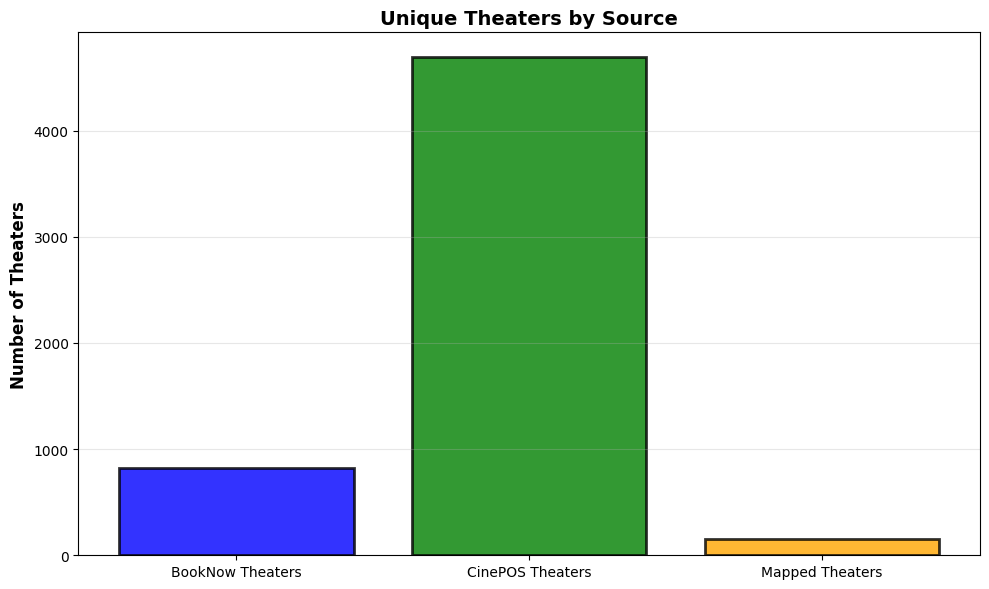

In [17]:
booknow_theater_count = booknow_visits['book_theater_id'].nunique()
cinepos_theater_count = cinePOS_theaters['cine_theater_id'].nunique()
mapped_theater_count = movie_theater_id_relation.shape[0]

print(f"BookNow Theaters: {booknow_theater_count}")
print(f"CinePOS Theaters: {cinepos_theater_count}")
print(f"Mapped Theaters: {mapped_theater_count}")

names = ['BookNow Theaters', 'CinePOS Theaters', 'Mapped Theaters']
counts = [booknow_theater_count, cinepos_theater_count, mapped_theater_count]
colors = ['blue', 'green', 'orange']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(names, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Theaters', fontsize=12, fontweight='bold')
ax.set_title('Unique Theaters by Source', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



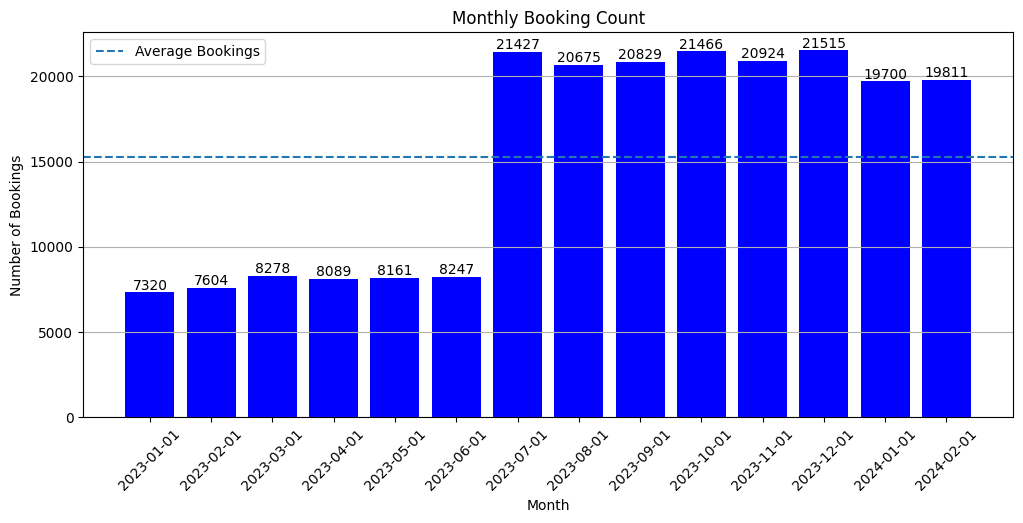

In [18]:
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])
booknow_visits['year_month'] = booknow_visits['show_date'].dt.to_period('M')

monthly_counts = booknow_visits.groupby('year_month').size()
monthly_counts.index = monthly_counts.index.to_timestamp()

plt.figure(figsize=(12, 5))
bars = plt.bar(monthly_counts.index.astype(str),
               monthly_counts.values,
               color='blue')

plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.title('Monthly Booking Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             str(int(height)),
             ha='center',
             va='bottom')

average = monthly_counts.mean()
plt.axhline(average, linestyle='--', label='Average Bookings')
plt.legend()

plt.show()

# **PREPROCESSING**

In [19]:
booknow_visits.head()

,book_theater_id,show_date,audience_count,year_month
0,book_00001,2023-01-13,50,2023-01
1,book_00001,2023-01-14,64,2023-01
2,book_00001,2023-01-15,58,2023-01
3,book_00001,2023-01-16,44,2023-01
4,book_00001,2023-01-18,12,2023-01


In [20]:
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'], format='%Y-%m-%d')
date_info['show_date'] = pd.to_datetime(date_info['show_date'], format='%Y-%m-%d')

booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'], format='%Y-%m-%d %H:%M:%S')
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'], format='%Y-%m-%d %H:%M:%S')

cinePOS_booking['show_datetime'] = pd.to_datetime(cinePOS_booking['show_datetime'], format='%Y-%m-%d %H:%M:%S')
cinePOS_booking['booking_datetime'] = pd.to_datetime(cinePOS_booking['booking_datetime'], format='%Y-%m-%d %H:%M:%S')

In [21]:
booknow_booking['show_date'] = booknow_booking['show_datetime'].dt.date
booknow_booking['show_date'] = pd.to_datetime(booknow_booking['show_date'])

In [22]:
booknow_booking['bookDiff_time_hours'] = (
    booknow_booking['show_datetime'] - booknow_booking['booking_datetime']).dt.total_seconds() / 3600

booknow_booking_agg = booknow_booking.groupby(['book_theater_id', 'show_date']).agg({
    'tickets_booked': ['sum', 'count', 'mean'],
    'bookDiff_time_hours': ['mean', 'median', 'min', 'max']
}).reset_index()

booknow_booking_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                                 for col in booknow_booking_agg.columns.values]

booknow_booking_agg.columns = ['book_theater_id', 'show_date', 
                                'total_tickets_booked', 'num_bookings', 'avg_tickets_per_booking',
                                'mean_bookDiff_time', 'median_bookDiff_time', 'min_bookDiff_time', 'max_bookDiff_time']

print(f"BookNow booking shape: {booknow_booking_agg.shape}")

BookNow booking shape: (21590, 9)


In [23]:
booknow_booking_agg.head()

,book_theater_id,show_date,total_tickets_booked,num_bookings,avg_tickets_per_booking,mean_bookDiff_time,median_bookDiff_time,min_bookDiff_time,max_bookDiff_time
0,book_00004,2023-02-27,12,1,12.000000,1.000000,1.0,1.0,1.0
1,book_00013,2023-01-04,2,1,2.000000,4.000000,4.0,4.0,4.0
2,book_00013,2023-01-08,3,1,3.000000,53.000000,53.0,53.0,53.0
3,book_00013,2023-01-09,25,12,2.083333,69.083333,57.5,1.0,195.0
4,book_00013,2023-01-10,5,2,2.500000,52.500000,52.5,0.0,105.0


In [24]:
cinePOS_booking['show_date'] = cinePOS_booking['show_datetime'].dt.date
cinePOS_booking['show_date'] = pd.to_datetime(cinePOS_booking['show_date'])

In [25]:
cinePOS_booking['lead_time_hours'] = (
    cinePOS_booking['show_datetime'] - cinePOS_booking['booking_datetime']).dt.total_seconds() / 3600

cinePOS_booking_agg = cinePOS_booking.groupby(['cine_theater_id', 'show_date']).agg({
    'tickets_sold': ['sum', 'count', 'mean'],
    'lead_time_hours': ['mean', 'median']
}).reset_index()

cinePOS_booking_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                                for col in cinePOS_booking_agg.columns.values]

cinePOS_booking_agg.columns = ['cine_theater_id', 'show_date',
                                'pos_total_tickets_sold', 'pos_num_transactions', 'pos_avg_tickets_per_transaction',
                                'pos_mean_bookDiff_time', 'pos_median_bookDiff_time']

print(f"CinePOS booking aggregates shape: {cinePOS_booking_agg.shape}")

CinePOS booking aggregates shape: (1120081, 7)


In [26]:
cinePOS_booking_agg.tail()

,cine_theater_id,show_date,pos_total_tickets_sold,pos_num_transactions,pos_avg_tickets_per_transaction,pos_mean_bookDiff_time,pos_median_bookDiff_time
1120076,cinePOS_13157,2024-02-28,2,1,2.0,27.0,27.0
1120077,cinePOS_13158,2024-02-28,4,2,2.0,357.0,357.0
1120078,cinePOS_13159,2024-02-28,7,1,7.0,45.0,45.0
1120079,cinePOS_13160,2024-02-28,6,1,6.0,22.0,22.0
1120080,cinePOS_13161,2024-02-28,2,1,2.0,3.0,3.0


In [27]:
df_main = booknow_visits.copy()
df_main = df_main.merge(date_info, on='show_date', how='left')
print(df_main.shape)
df_main.head()

(214046, 5)


,book_theater_id,show_date,audience_count,year_month,day_of_week
0,book_00001,2023-01-13,50,2023-01,Friday
1,book_00001,2023-01-14,64,2023-01,Saturday
2,book_00001,2023-01-15,58,2023-01,Sunday
3,book_00001,2023-01-16,44,2023-01,Monday
4,book_00001,2023-01-18,12,2023-01,Wednesday


In [28]:
df_main = df_main.merge(
    booknow_theaters[['book_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']], 
    on='book_theater_id', 
    how='left'
)
print(df_main.shape)

print("Missing values in theater feature:")
print(df_main[['theater_type', 'theater_area', 'latitude', 'longitude']].isna().sum())

df_main.head()

(214046, 9)
Missing values in theater feature:
theater_type    133896
theater_area    133896
latitude        133896
longitude       133896
dtype: int64


,book_theater_id,show_date,audience_count,year_month,day_of_week,theater_type,theater_area,latitude,longitude
0,book_00001,2023-01-13,50,2023-01,Friday,Drama,Area_002,23.00441,79.934515
1,book_00001,2023-01-14,64,2023-01,Saturday,Drama,Area_002,23.00441,79.934515
2,book_00001,2023-01-15,58,2023-01,Sunday,Drama,Area_002,23.00441,79.934515
3,book_00001,2023-01-16,44,2023-01,Monday,Drama,Area_002,23.00441,79.934515
4,book_00001,2023-01-18,12,2023-01,Wednesday,Drama,Area_002,23.00441,79.934515


In [29]:
df_main = df_main.merge(booknow_booking_agg, on=['book_theater_id', 'show_date'], how='left')

print(df_main.shape)
print("Booking feature coverage:")

df_main.head()

(214046, 16)
Booking feature coverage:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,book_theater_id,show_date,audience_count,year_month,day_of_week,theater_type,theater_area,latitude,longitude,total_tickets_booked,num_bookings,avg_tickets_per_booking,mean_bookDiff_time,median_bookDiff_time,min_bookDiff_time,max_bookDiff_time
0,book_00001,2023-01-13,50,2023-01,Friday,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,book_00001,2023-01-14,64,2023-01,Saturday,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,book_00001,2023-01-15,58,2023-01,Sunday,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,book_00001,2023-01-16,44,2023-01,Monday,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,book_00001,2023-01-18,12,2023-01,Wednesday,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_main = df_main.merge(movie_theater_id_relation, on='book_theater_id', how='left')
print(f"Theaters with CinePOS mapping: {df_main['cine_theater_id'].notna().sum()} / {len(df_main)}")

Theaters with CinePOS mapping: 38976 / 214046


In [31]:
df_main = df_main.merge(cinePOS_booking_agg, on=['cine_theater_id', 'show_date'], how='left')

In [32]:
cinePOS_theaters_renamed = cinePOS_theaters.rename(columns={
    'theater_type': 'pos_theater_type',
    'theater_area': 'pos_theater_area',
    'latitude': 'pos_latitude',
    'longitude': 'pos_longitude'
})

In [33]:
df_main = df_main.merge(
    cinePOS_theaters_renamed[['cine_theater_id', 'pos_theater_type', 'pos_theater_area', 'pos_latitude', 'pos_longitude']], 
    on='cine_theater_id', 
    how='left'
)

print(df_main.shape)

print(f"Rows with POS booking data: {df_main['pos_total_tickets_sold'].notna().sum()}")
print(f"Rows with POS location data: {df_main['pos_latitude'].notna().sum()}")

df_main.head()

(214046, 26)
Rows with POS booking data: 11150
Rows with POS location data: 3309


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,book_theater_id,show_date,audience_count,year_month,day_of_week,theater_type,theater_area,latitude,longitude,total_tickets_booked,...,cine_theater_id,pos_total_tickets_sold,pos_num_transactions,pos_avg_tickets_per_transaction,pos_mean_bookDiff_time,pos_median_bookDiff_time,pos_theater_type,pos_theater_area,pos_latitude,pos_longitude
0,book_00001,2023-01-13,50,2023-01,Friday,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,book_00001,2023-01-14,64,2023-01,Saturday,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,book_00001,2023-01-15,58,2023-01,Sunday,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,book_00001,2023-01-16,44,2023-01,Monday,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,book_00001,2023-01-18,12,2023-01,Wednesday,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
print(list(df_main.columns))

['book_theater_id', 'show_date', 'audience_count', 'year_month', 'day_of_week', 'theater_type', 'theater_area', 'latitude', 'longitude', 'total_tickets_booked', 'num_bookings', 'avg_tickets_per_booking', 'mean_bookDiff_time', 'median_bookDiff_time', 'min_bookDiff_time', 'max_bookDiff_time', 'cine_theater_id', 'pos_total_tickets_sold', 'pos_num_transactions', 'pos_avg_tickets_per_transaction', 'pos_mean_bookDiff_time', 'pos_median_bookDiff_time', 'pos_theater_type', 'pos_theater_area', 'pos_latitude', 'pos_longitude']


In [35]:
df_main = df_main.drop('year_month', axis=1)

In [36]:
print("Final columns:", list(df_main.columns))
print(df_main.isna().sum().sort_values(ascending=False))

Final columns: ['book_theater_id', 'show_date', 'audience_count', 'day_of_week', 'theater_type', 'theater_area', 'latitude', 'longitude', 'total_tickets_booked', 'num_bookings', 'avg_tickets_per_booking', 'mean_bookDiff_time', 'median_bookDiff_time', 'min_bookDiff_time', 'max_bookDiff_time', 'cine_theater_id', 'pos_total_tickets_sold', 'pos_num_transactions', 'pos_avg_tickets_per_transaction', 'pos_mean_bookDiff_time', 'pos_median_bookDiff_time', 'pos_theater_type', 'pos_theater_area', 'pos_latitude', 'pos_longitude']
pos_longitude                      210737
pos_latitude                       210737
pos_median_bookDiff_time           202896
pos_mean_bookDiff_time             202896
pos_avg_tickets_per_transaction    202896
pos_num_transactions               202896
pos_total_tickets_sold             202896
pos_theater_area                   197014
pos_theater_type                   197014
min_bookDiff_time                  193005
max_bookDiff_time                  193005
median_bookDif

# **FEATURE ENGINEERING**

**Creating new date columns and deriving audience to theater ratios**

In [37]:
# df_main['year'] = df_main['show_date'].dt.year
df_main['month'] = df_main['show_date'].dt.month
df_main['day'] = df_main['show_date'].dt.day
df_main['day_of_week'] = df_main['show_date'].dt.day_name()
df_main['day_of_year'] = df_main['show_date'].dt.dayofyear
df_main['week_of_year'] = df_main['show_date'].dt.isocalendar().week

In [38]:
df_main['is_weekend'] = df_main['show_date'].dt.dayofweek.isin([5, 6]).astype(int)

In [39]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Autumn'

In [40]:
df_main['season'] = df_main['month'].apply(get_season)
min_date = df_main['show_date'].min()
# df_main['days_since_start'] = (df_main['show_date'] - min_date).dt.days

print("New Columns created.")
df_main[['show_date', 'day_of_week', 'is_weekend', 'season', 'month']].head()

New Columns created.


,show_date,day_of_week,is_weekend,season,month
0,2023-01-13,Friday,0,Winter,1
1,2023-01-14,Saturday,1,Winter,1
2,2023-01-15,Sunday,1,Winter,1
3,2023-01-16,Monday,0,Winter,1
4,2023-01-18,Wednesday,0,Winter,1


In [41]:
df_main['dow_numeric'] = df_main['show_date'].dt.dayofweek
df_main['dow_sin'] = np.sin(2 * np.pi * df_main['dow_numeric'] / 7)
df_main['dow_cos'] = np.cos(2 * np.pi * df_main['dow_numeric'] / 7)

print("Cyclical encodings created")

Cyclical encodings created


In [42]:
dec_sample = df_main[df_main['month'] == 12].iloc[0]
jan_sample = df_main[df_main['month'] == 1].iloc[0]

In [43]:
indian_holidays = pd.to_datetime([
    # 2023
    '2023-01-26',  # Republic Day
    '2023-03-08',  # Holi
    '2023-03-22',  # Gudi Padwa
    '2023-04-07',  # Good Friday
    '2023-04-14',  # Ambedkar Jayanti / Tamil New Year
    '2023-04-22',  # Eid al-Fitr
    '2023-08-15',  # Independence Day
    '2023-09-19',  # Ganesh Chaturthi
    '2023-10-24',  # Dussehra
    '2023-11-12',  # Diwali
    '2023-11-13',  # Diwali (Day 2)
    '2023-11-27',  # Guru Nanak Jayanti
    '2023-12-25',  # Christmas
    
    # 2024
    '2024-01-26',  # Republic Day
    '2024-03-08',  # Maha Shivaratri
    '2024-03-25',  # Holi
    '2024-04-11',  # Eid al-Fitr
    '2024-04-17',  # Ram Navami
    '2024-04-21',  # Mahavir Jayanti
    '2024-08-15',  # Independence Day
    '2024-08-26',  # Janmashtami
    '2024-10-12',  # Dussehra
    '2024-11-01',  # Diwali
    '2024-11-15',  # Guru Nanak Jayanti
    '2024-12-25',  # Christmas
])

df_main['is_holiday'] = df_main['show_date'].isin(indian_holidays).astype(int)

In [44]:
def days_to_next_holiday(date, holidays):
    future_holidays = holidays[holidays > date]
    if len(future_holidays) > 0:
        return (future_holidays.min() - date).days
    else:
        return 999 

df_main['days_to_next_holiday'] = df_main['show_date'].apply(
    lambda x: days_to_next_holiday(x, indian_holidays)
)

In [45]:
def days_since_holiday(date, holidays):
    past_holidays = holidays[holidays < date]
    if len(past_holidays) > 0:
        return (date - past_holidays.max()).days
    else:
        return 999

df_main['days_since_holiday'] = df_main['show_date'].apply(
    lambda x: days_since_holiday(x, indian_holidays)
)

In [46]:
print(f"Total holidays in dataset: {df_main['is_holiday'].sum()}")

print(df_main[df_main['is_holiday'] == 1][['show_date', 'day_of_week']].drop_duplicates().head(10))

Total holidays in dataset: 6599
     show_date day_of_week
11  2023-01-26    Thursday
45  2023-03-08   Wednesday
56  2023-03-22   Wednesday
71  2023-04-07      Friday
77  2023-04-14      Friday
84  2023-04-22    Saturday
232 2023-10-24     Tuesday
250 2023-11-12      Sunday
310 2024-01-26      Friday
577 2023-11-27      Monday


In [47]:
df_main['is_month_start'] = (df_main['day'] <= 5).astype(int)
df_main['is_month_end'] = (df_main['day'] >= 25).astype(int)
df_main['quarter'] = df_main['show_date'].dt.quarter
df_main['week_of_month'] = ((df_main['day'] - 1) // 7 + 1).clip(upper=5)

In [48]:
df_main['days_to_weekend'] = df_main['dow_numeric'].apply(
    lambda x: 5 - x if x < 5 else 0)
df_main['days_from_weekend'] = df_main['dow_numeric'].apply(
    lambda x: x - 6 if x == 6 else (x if x < 6 else 0))

In [49]:
df_main['has_booking_data'] = df_main['total_tickets_booked'].notna().astype(int)
df_main['has_pos_data'] = df_main['pos_total_tickets_sold'].notna().astype(int)
df_main['has_theater_metadata'] = df_main['theater_type'].notna().astype(int)
df_main['has_pos_location'] = df_main['pos_latitude'].notna().astype(int)

print(f"has_booking_data: {df_main['has_booking_data'].sum()} theaters")
print(f"has_pos_data: {df_main['has_pos_data'].sum()} theaters")
print(f"has_theater_metadata: {df_main['has_theater_metadata'].sum()} theaters")
print(f"has_pos_location: {df_main['has_pos_location'].sum()} theaters")

has_booking_data: 21041 theaters
has_pos_data: 11150 theaters
has_theater_metadata: 80150 theaters
has_pos_location: 3309 theaters


In [50]:
df_main['booking_to_audience_ratio'] = np.where(
    (df_main['total_tickets_booked'].notna()) & (df_main['audience_count'] > 0),
    df_main['total_tickets_booked'] / df_main['audience_count'],
    np.nan
)

In [51]:
df_main['pos_to_audience_ratio'] = np.where(
    (df_main['pos_total_tickets_sold'].notna()) & (df_main['audience_count'] > 0),
    df_main['pos_total_tickets_sold'] / df_main['audience_count'],
    np.nan
)

In [52]:
df_main['total_ticket_volume'] = df_main[['total_tickets_booked', 'pos_total_tickets_sold']].sum(axis=1, skipna=True)
df_main['has_dual_booking'] = ((df_main['has_booking_data'] == 1) & (df_main['has_pos_data'] == 1)).astype(int)

In [53]:
print(f"booking_to_audience_ratio: {df_main['booking_to_audience_ratio'].notna().sum()} valid values")
print(f"pos_to_audience_ratio: {df_main['pos_to_audience_ratio'].notna().sum()} valid values")
print(f"Theaters with dual booking: {df_main['has_dual_booking'].sum()}")

booking_to_audience_ratio: 21041 valid values
pos_to_audience_ratio: 11150 valid values
Theaters with dual booking: 4299


In [54]:
df_main = df_main.drop(['theater_avg_audience', 'theater_median_audience', 
                        'theater_std_audience', 'theater_total_shows'], 
                       axis=1, errors='ignore')

print(df_main.shape)

(214046, 51)


In [55]:
df_main.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,book_theater_id,show_date,audience_count,day_of_week,theater_type,theater_area,latitude,longitude,total_tickets_booked,num_bookings,...,days_to_weekend,days_from_weekend,has_booking_data,has_pos_data,has_theater_metadata,has_pos_location,booking_to_audience_ratio,pos_to_audience_ratio,total_ticket_volume,has_dual_booking
0,book_00001,2023-01-13,50,Friday,Drama,Area_002,23.00441,79.934515,NaN,NaN,...,1,4,0,0,1,0,NaN,NaN,0.0,0
1,book_00001,2023-01-14,64,Saturday,Drama,Area_002,23.00441,79.934515,NaN,NaN,...,0,5,0,0,1,0,NaN,NaN,0.0,0
2,book_00001,2023-01-15,58,Sunday,Drama,Area_002,23.00441,79.934515,NaN,NaN,...,0,0,0,0,1,0,NaN,NaN,0.0,0
3,book_00001,2023-01-16,44,Monday,Drama,Area_002,23.00441,79.934515,NaN,NaN,...,5,0,0,0,1,0,NaN,NaN,0.0,0
4,book_00001,2023-01-18,12,Wednesday,Drama,Area_002,23.00441,79.934515,NaN,NaN,...,3,2,0,0,1,0,NaN,NaN,0.0,0


# **IMPUTATION**

In [56]:
modeling_cols = [col for col in df_main.columns if col not in ['book_theater_id', 'show_date', 'audience_count', 'cine_theater_id']]

missing_counts = df_main[modeling_cols].isna().sum()
missing_percent = (missing_counts / len(df_main) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df.to_string(index=False))

                         Column  Missing_Count  Missing_Percent
                  pos_longitude         210737            98.45
                   pos_latitude         210737            98.45
         pos_total_tickets_sold         202896            94.79
           pos_num_transactions         202896            94.79
       pos_median_bookDiff_time         202896            94.79
         pos_mean_bookDiff_time         202896            94.79
pos_avg_tickets_per_transaction         202896            94.79
          pos_to_audience_ratio         202896            94.79
               pos_theater_type         197014            92.04
               pos_theater_area         197014            92.04
           median_bookDiff_time         193005            90.17
              min_bookDiff_time         193005            90.17
              max_bookDiff_time         193005            90.17
             mean_bookDiff_time         193005            90.17
        avg_tickets_per_booking         

In [57]:
categorical_cols = ['theater_type', 'theater_area', 'pos_theater_type', 'pos_theater_area', 'day_of_week', 'season']

for col in categorical_cols:
    if col in df_main.columns:
        df_main[col] = df_main[col].fillna('Unknown')

In [58]:
print(df_main[categorical_cols].isna().sum())

theater_type        0
theater_area        0
pos_theater_type    0
pos_theater_area    0
day_of_week         0
season              0
dtype: int64


In [59]:
zero_fill_cols = [
    'total_tickets_booked', 'num_bookings', 'avg_tickets_per_booking',
    'mean_bookDiff_time', 'median_bookDiff_time', 'min_bookDiff_time', 'max_bookDiff_time',
    'pos_total_tickets_sold', 'pos_num_transactions', 'pos_avg_tickets_per_transaction',
    'pos_mean_bookDiff_time', 'pos_median_bookDiff_time',
    'booking_to_audience_ratio', 'pos_to_audience_ratio'
]

In [60]:
for col in zero_fill_cols:
    if col in df_main.columns:
        df_main[col] = df_main[col].fillna(0)

***new method for imputing... EXPERIMENTING***

In [61]:
location_cols = ['latitude', 'longitude', 'pos_latitude', 'pos_longitude']
print("Missing a lot of rows")

Missing a lot of rows


In [62]:
df_main = df_main.drop(columns=location_cols, errors='ignore')

In [63]:
# # ===== LOCATION FEATURES - OPTION B: KEEP WITH AWARENESS FLAGS =====
# print("\n" + "="*70)
# print("LOCATION FEATURES - SMART IMPUTATION WITH AWARENESS FLAGS")
# print("="*70)

# # Step 1: Create flags BEFORE imputation (to mark real vs imputed)
# df_main['has_real_location'] = df_main['latitude'].notna().astype(int)
# df_main['has_real_pos_location'] = df_main['pos_latitude'].notna().astype(int)

# print(f"✓ Created location awareness flags")
# print(f"  Theaters with real BookNow location: {df_main['has_real_location'].sum():,} ({df_main['has_real_location'].mean()*100:.1f}%)")
# print(f"  Theaters with real POS location: {df_main['has_real_pos_location'].sum():,} ({df_main['has_real_pos_location'].mean()*100:.1f}%)")

# # Step 2: NOW impute with median (model will know which are real via flags)
# print("\nImputing missing coordinates with median:")
# for col in ['latitude', 'longitude']:
#     if col in df_main.columns and df_main[col].notna().sum() > 0:
#         median_val = df_main[col].median()
#         df_main[col] = df_main[col].fillna(median_val)
#         print(f"  ✓ {col}: filled with {median_val:.6f}")

# for col in ['pos_latitude', 'pos_longitude']:
#     if col in df_main.columns and df_main[col].notna().sum() > 0:
#         median_val = df_main[col].median()
#         df_main[col] = df_main[col].fillna(median_val)
#         print(f"  ✓ {col}: filled with {median_val:.6f}")

# print("\n✓ Location features preserved with awareness flags")
# print("  Model can learn: 'Use location only when has_real_location=1'")

In [64]:
feature_cols = [col for col in df_main.columns if col not in ['book_theater_id', 'cine_theater_id', 'show_date', 'audience_count']]

feature_missing = df_main[feature_cols].isna().sum()
feature_missing = feature_missing[feature_missing > 0]
    
if len(feature_missing) == 0:
    print(f"Total feature columns: {len(feature_cols)}")
    print(f"Dataset ready for modeling: {df_main.shape}")

Total feature columns: 43
Dataset ready for modeling: (214046, 47)


In [65]:
print("Final columns:", list(df_main.columns))

Final columns: ['book_theater_id', 'show_date', 'audience_count', 'day_of_week', 'theater_type', 'theater_area', 'total_tickets_booked', 'num_bookings', 'avg_tickets_per_booking', 'mean_bookDiff_time', 'median_bookDiff_time', 'min_bookDiff_time', 'max_bookDiff_time', 'cine_theater_id', 'pos_total_tickets_sold', 'pos_num_transactions', 'pos_avg_tickets_per_transaction', 'pos_mean_bookDiff_time', 'pos_median_bookDiff_time', 'pos_theater_type', 'pos_theater_area', 'month', 'day', 'day_of_year', 'week_of_year', 'is_weekend', 'season', 'dow_numeric', 'dow_sin', 'dow_cos', 'is_holiday', 'days_to_next_holiday', 'days_since_holiday', 'is_month_start', 'is_month_end', 'quarter', 'week_of_month', 'days_to_weekend', 'days_from_weekend', 'has_booking_data', 'has_pos_data', 'has_theater_metadata', 'has_pos_location', 'booking_to_audience_ratio', 'pos_to_audience_ratio', 'total_ticket_volume', 'has_dual_booking']


# **ENCODING & SCALING**

In [66]:
categorical_features = [
    'day_of_week', 'theater_type', 'theater_area', 
    'pos_theater_type', 'pos_theater_area', 'season'
]

numeric_features = [
    'month', 'day', 'day_of_year', 'week_of_year',
    'dow_sin', 'dow_cos',
    'days_to_next_holiday', 'days_since_holiday',
    'quarter', 'week_of_month', 'days_to_weekend', 'days_from_weekend',
    'total_tickets_booked', 'num_bookings', 'avg_tickets_per_booking',
    'mean_bookDiff_time', 'median_bookDiff_time', 'min_bookDiff_time', 'max_bookDiff_time',
    'pos_total_tickets_sold', 'pos_num_transactions', 'pos_avg_tickets_per_transaction',
    'pos_mean_bookDiff_time', 'pos_median_bookDiff_time',
    'booking_to_audience_ratio', 'pos_to_audience_ratio', 'total_ticket_volume',
    'theater_avg_audience', 'theater_median_audience', 
    'theater_std_audience', 'theater_total_shows'
]

***if option B in imputing is selected then remember to make the changes here as well (the option of adding a flag instead of dropping location cols)***

In [67]:
binary_features = [
    'is_weekend', 'has_booking_data', 'has_pos_data', 
    'has_theater_metadata', 'has_pos_location', 'has_dual_booking',
    'is_holiday', 'is_month_start', 'is_month_end',
]

In [68]:
print(f"Numeric: {len(numeric_features)} features")
print(f"Categorical: {len(categorical_features)} features")
print(f"Binary: {len(binary_features)} features")
print(f"Total: {len(numeric_features) + len(categorical_features) + len(binary_features)} features")

Numeric: 31 features
Categorical: 6 features
Binary: 9 features
Total: 46 features


# **BASE MODEL**

In [69]:
df_sorted = df_main.sort_values('show_date').reset_index(drop=True)
split_idx = int(len(df_sorted) * 0.8)

In [70]:
train_data = df_sorted.iloc[:split_idx].copy()
test_data = df_sorted.iloc[split_idx:].copy()

In [71]:
print(f"Train: {train_data['show_date'].min()} to {train_data['show_date'].max()}")
print(f"Test: {test_data['show_date'].min()} to {test_data['show_date'].max()}")

Train: 2023-01-01 00:00:00 to 2023-12-26 00:00:00
Test: 2023-12-26 00:00:00 to 2024-02-28 00:00:00


In [72]:
theater_stats_train = train_data.groupby('book_theater_id')['audience_count'].agg([
    ('theater_avg_audience', 'mean'),
    ('theater_median_audience', 'median'),
    ('theater_std_audience', 'std'),
    ('theater_total_shows', 'count')
]).reset_index()

In [73]:
train_data = train_data.merge(theater_stats_train, on='book_theater_id', how='left')
test_data = test_data.merge(theater_stats_train, on='book_theater_id', how='left')

In [74]:
train_median_avg = theater_stats_train['theater_avg_audience'].median()
train_median_median = theater_stats_train['theater_median_audience'].median()
train_median_std = theater_stats_train['theater_std_audience'].median()

In [75]:
for df in [train_data, test_data]:
    df['theater_avg_audience'] = df['theater_avg_audience'].fillna(train_median_avg)
    df['theater_median_audience'] = df['theater_median_audience'].fillna(train_median_median)
    df['theater_std_audience'] = df['theater_std_audience'].fillna(train_median_std)
    df['theater_std_audience'] = df['theater_std_audience'].fillna(0)
    df['theater_total_shows'] = df['theater_total_shows'].fillna(0)

In [76]:
print(f"Avg: {train_median_avg:.2f}, Median: {train_median_median:.2f}, Std: {train_median_std:.2f}")

Avg: 38.23, Median: 34.00, Std: 19.71


In [77]:
X_train = train_data.drop(['audience_count', 'book_theater_id', 'show_date', 'cine_theater_id'], 
                          axis=1, errors='ignore')
y_train = train_data['audience_count']

In [78]:
X_test = test_data.drop(['audience_count', 'book_theater_id', 'show_date', 'cine_theater_id'], 
                        axis=1, errors='ignore')
y_test = test_data['audience_count']

In [79]:
print(f"Train set: {X_train.shape[0]:,} rows, {X_train.shape[1]} features")
print(f"Target mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")

print(f"Test set: {X_test.shape[0]:,} rows, {X_test.shape[1]} features")
print(f"Target mean: {y_test.mean():.2f}, std: {y_test.std():.2f}")

Train set: 171,236 rows, 47 features
Target mean: 41.83, std: 33.07
Test set: 42,810 rows, 47 features
Target mean: 40.76, std: 31.84


In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ],
    remainder='drop'
)

In [81]:
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['month', 'day',
                                                   'day_of_year',
                                                   'week_of_year', 'dow_sin',
                                                   'dow_cos',
                                                   'days_to_next_holiday',
                                                   'days_since_holiday',
                                                   'quarter', 'week_of_month',
                                                   'days_to_weekend',
                                                   'days_from_weekend',
                                                   'total_tickets_booked',
                                                   'num_bookings',
                                                   'avg_tickets_per_booking',
                                                   'mean_bookDiff_time',
                                                   'medi...
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['day_of_week',
                                                   'theater_type',
                                                   'theater_area',
                                                   'pos_theater_type',
                                                   'pos_theater_area',
                                                   'season']),
                                                 ('bin', 'passthrough',
                                                  ['is_weekend',
                                                   'has_booking_data',
                                                   'has_pos_data',
                                                   'has_theater_metadata',
                                                   'has_pos_location',
                                                   'has_dual_booking',
                                                   'is_holiday',
                                                   'is_month_start',
                                                   'is_month_end'])])),
                ('regressor', Ridge())])

In [82]:
y_train_pred = baseline_pipeline.predict(X_train)
y_test_pred = baseline_pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

In [83]:
print("Training set performance")
print(f"R2 Score: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAE: {train_mae:.2f}")

print("Test set performance")
print(f"R2 Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")

Training set performance
R2 Score: 0.4809
RMSE: 23.83
MAE: 15.90
Test set performance
R2 Score: 0.4107
RMSE: 24.44
MAE: 16.11


# **MODELLING**

**XGBOOST MODEL**

In [84]:
X_train_full = train_data.drop(['audience_count', 'book_theater_id', 'show_date', 'cine_theater_id'], axis=1, errors='ignore')
y_train_full = train_data['audience_count']

X_test_final = test_data.drop(['audience_count', 'book_theater_id', 'show_date', 'cine_theater_id'], axis=1, errors='ignore')
y_test_final = test_data['audience_count']

print(f"Training data: {X_train_full.shape}")
print(f"Test data: {X_test_final.shape}")

Training data: (171236, 47)
Test data: (42810, 47)


In [85]:
xgb_params = {
    'objective': 'reg:tweedie',
    'eval_metric': 'rmse',
    'max_depth': 4,
    'learning_rate': 0.02,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 20,
    'gamma': 0.2,
    'reg_alpha': 1.0,
    'reg_lambda': 10.0,
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1,
    'tweedie_variance_power':1.5
}

print("Running TimeSeriesSplit Cross-Validation (3 folds)")
tscv = TimeSeriesSplit(n_splits=3)

Running TimeSeriesSplit Cross-Validation (3 folds)


In [86]:
cv_scores = {'r2': [], 'rmse': [], 'mae': []}
fold_num = 1

for train_idx, val_idx in tscv.split(X_train_full):
    print(f"Fold number: {fold_num}")
    
    X_fold_train, X_fold_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_fold_train, y_fold_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    preprocessor_fold = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
            ('bin', 'passthrough', binary_features)
        ],
        remainder='drop'
    )
    
    X_fold_train_scaled = preprocessor_fold.fit_transform(X_fold_train)
    X_fold_val_scaled = preprocessor_fold.transform(X_fold_val)

    dtrain = xgb.DMatrix(X_fold_train_scaled, label=y_fold_train)
    dval = xgb.DMatrix(X_fold_val_scaled, label=y_fold_val)
    
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    y_fold_pred = model.predict(dval)
    y_fold_pred = np.clip(y_fold_pred, 0, None)
    
    fold_r2 = r2_score(y_fold_val, y_fold_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred))
    fold_mae = mean_absolute_error(y_fold_val, y_fold_pred)
    
    cv_scores['r2'].append(fold_r2)
    cv_scores['rmse'].append(fold_rmse)
    cv_scores['mae'].append(fold_mae)
    
    print(f"  R² = {fold_r2:.4f}, RMSE = {fold_rmse:.2f}, MAE = {fold_mae:.2f}")
    fold_num += 1

Fold number: 1


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  R² = 0.4823, RMSE = 23.16, MAE = 15.33
Fold number: 2


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  R² = 0.4922, RMSE = 22.61, MAE = 14.65
Fold number: 3


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  R² = 0.5658, RMSE = 22.33, MAE = 14.23


In [87]:
print(f"Average R²   = {np.mean(cv_scores['r2']):.4f} (±{np.std(cv_scores['r2']):.4f})")
print(f"Average RMSE = {np.mean(cv_scores['rmse']):.2f} (±{np.std(cv_scores['rmse']):.2f})")
print(f"Average MAE  = {np.mean(cv_scores['mae']):.2f} (±{np.std(cv_scores['mae']):.2f})")

Average R²   = 0.5134 (±0.0372)
Average RMSE = 22.70 (±0.34)
Average MAE  = 14.74 (±0.45)


In [88]:
# FULL SET TRAINING

In [89]:
print("Training final XGBoost model on full training set")

preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ],
    remainder='drop'
)

X_train_scaled = preprocessor_final.fit_transform(X_train_full)
X_test_scaled = preprocessor_final.transform(X_test_final)

dtrain_final = xgb.DMatrix(X_train_scaled, label=y_train_full)
dtest_final = xgb.DMatrix(X_test_scaled, label=y_test_final)

xgb_final = xgb.train(
    xgb_params,
    dtrain_final,
    num_boost_round=1000,
    evals=[(dtrain_final, 'train'), (dtest_final, 'test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

Training final XGBoost model on full training set
[0]	train-rmse:48.07940	test-rmse:46.45817
[100]	train-rmse:28.29128	test-rmse:26.75090
[200]	train-rmse:23.67091	test-rmse:22.40519
[300]	train-rmse:23.05264	test-rmse:21.81730
[400]	train-rmse:22.76566	test-rmse:21.60022
[500]	train-rmse:22.57836	test-rmse:21.40638
[600]	train-rmse:22.42796	test-rmse:21.26194
[700]	train-rmse:22.30988	test-rmse:21.16870
[800]	train-rmse:22.20674	test-rmse:21.12534
[900]	train-rmse:22.10511	test-rmse:21.03404
[999]	train-rmse:22.02017	test-rmse:21.00102


In [90]:
y_train_pred_xgb = xgb_final.predict(dtrain_final)
y_test_pred_xgb = xgb_final.predict(dtest_final)

y_train_pred_xgb = np.clip(y_train_pred_xgb, 0, None)
y_test_pred_xgb = np.clip(y_test_pred_xgb, 0, None)

train_r2_xgb = r2_score(y_train_full, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test_final, y_test_pred_xgb)

train_rmse_xgb = np.sqrt(mean_squared_error(y_train_full, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test_final, y_test_pred_xgb))

train_mae_xgb = mean_absolute_error(y_train_full, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test_final, y_test_pred_xgb)

In [91]:
print(f"TRAINING SET:")
print(f"R² Score:{train_r2_xgb:.4f}")
print(f"RMSE:{train_rmse_xgb:.2f}")
print(f"MAE:{train_mae_xgb:.2f}")
print(f"TEST SET:")
print(f"R² Score:{test_r2_xgb:.4f}")
print(f"RMSE:{test_rmse_xgb:.2f}")
print(f"MAE:{test_mae_xgb:.2f}")

print(f"Negative predictions: {(y_test_pred_xgb < 0).sum()}")

TRAINING SET:
R² Score:0.5568
RMSE:22.02
MAE:14.22
TEST SET:
R² Score:0.5650
RMSE:21.00
MAE:14.18
Negative predictions: 0


In [92]:
xgb_test_predictions = y_test_pred_xgb.copy()

**LIGHTGBM MODEL**

In [93]:
lgb_params = {
    'objective': 'poisson',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_data_in_leaf': 30,
    'lambda_l1': 1.0,
    'lambda_l2': 10.0,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1
}

print("Running TimeSeriesSplit Cross-Validation (3 folds)")
tscv = TimeSeriesSplit(n_splits=3)

Running TimeSeriesSplit Cross-Validation (3 folds)


In [94]:
cv_scores_lgb = {'r2': [], 'rmse': [], 'mae': []}
fold_num = 1

for train_idx, val_idx in tscv.split(X_train_full):
    print(f"Fold number: {fold_num}")
    
    X_fold_train, X_fold_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_fold_train, y_fold_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    preprocessor_fold = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
            ('bin', 'passthrough', binary_features)
        ],
        remainder='drop'
    )
    
    X_fold_train_scaled = preprocessor_fold.fit_transform(X_fold_train)
    X_fold_val_scaled = preprocessor_fold.transform(X_fold_val)
    
    dtrain_lgb = lgb.Dataset(X_fold_train_scaled, label=y_fold_train)
    dval_lgb = lgb.Dataset(X_fold_val_scaled, label=y_fold_val, reference=dtrain_lgb)
    
    model_lgb = lgb.train(
        lgb_params,
        dtrain_lgb,
        num_boost_round=1000,
        valid_sets=[dtrain_lgb, dval_lgb],
        valid_names=['train', 'val'],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    y_fold_pred = model_lgb.predict(X_fold_val_scaled, num_iteration=model_lgb.best_iteration)
    y_fold_pred = np.clip(y_fold_pred, 0, None)
    
    fold_r2 = r2_score(y_fold_val, y_fold_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred))
    fold_mae = mean_absolute_error(y_fold_val, y_fold_pred)
    
    cv_scores_lgb['r2'].append(fold_r2)
    cv_scores_lgb['rmse'].append(fold_rmse)
    cv_scores_lgb['mae'].append(fold_mae)
    
    print(f"  R² = {fold_r2:.4f}, RMSE = {fold_rmse:.2f}, MAE = {fold_mae:.2f}")
    fold_num += 1

Fold number: 1


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[797]	train's rmse: 22.6708	val's rmse: 22.9468
  R² = 0.4916, RMSE = 22.95, MAE = 15.22
Fold number: 2


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[605]	train's rmse: 22.8241	val's rmse: 22.6523
  R² = 0.4905, RMSE = 22.65, MAE = 14.85
Fold number: 3


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 22.3101	val's rmse: 22.5325
  R² = 0.5577, RMSE = 22.53, MAE = 14.49


In [95]:
print(f"Average R²= {np.mean(cv_scores_lgb['r2']):.4f}, ({np.std(cv_scores_lgb['r2']):.4f})")
print(f"Average RMSE= {np.mean(cv_scores_lgb['rmse']):.2f}, ({np.std(cv_scores_lgb['rmse']):.2f})")
print(f"Average MAE= {np.mean(cv_scores_lgb['mae']):.2f}, ({np.std(cv_scores_lgb['mae']):.2f})")

Average R²= 0.5132, (0.0314)
Average RMSE= 22.71, (0.17)
Average MAE= 14.85, (0.30)


In [96]:
# TRAINNG FULL SET

In [97]:
print("Training final LightGBM model on full training set")

dtrain_lgb_final = lgb.Dataset(X_train_scaled, label=y_train_full)
dtest_lgb_final = lgb.Dataset(X_test_scaled, label=y_test_final, reference=dtrain_lgb_final)

Training final LightGBM model on full training set


In [98]:
lgb_final = lgb.train(
    lgb_params,
    dtrain_lgb_final,
    num_boost_round= 1000,
    valid_sets=[dtrain_lgb_final, dtest_lgb_final],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 25.8144	test's rmse: 24.6232
[200]	train's rmse: 24.0323	test's rmse: 22.8759
[300]	train's rmse: 23.4039	test's rmse: 22.2264
[400]	train's rmse: 23.0476	test's rmse: 21.8813
[500]	train's rmse: 22.8044	test's rmse: 21.6793
[600]	train's rmse: 22.6326	test's rmse: 21.5135
[700]	train's rmse: 22.4973	test's rmse: 21.3802
[800]	train's rmse: 22.3851	test's rmse: 21.3156
[900]	train's rmse: 22.2917	test's rmse: 21.2324
[1000]	train's rmse: 22.2052	test's rmse: 21.1949
Did not meet early stopping. Best iteration is:
[990]	train's rmse: 22.2154	test's rmse: 21.1886


In [99]:
y_train_pred_lgb = lgb_final.predict(X_train_scaled, num_iteration=lgb_final.best_iteration)
y_test_pred_lgb = lgb_final.predict(X_test_scaled, num_iteration=lgb_final.best_iteration)

y_train_pred_lgb = np.clip(y_train_pred_lgb, 0, None)
y_test_pred_lgb = np.clip(y_test_pred_lgb, 0, None)

train_r2_lgb = r2_score(y_train_full, y_train_pred_lgb)
test_r2_lgb = r2_score(y_test_final, y_test_pred_lgb)

train_rmse_lgb = np.sqrt(mean_squared_error(y_train_full, y_train_pred_lgb))
test_rmse_lgb = np.sqrt(mean_squared_error(y_test_final, y_test_pred_lgb))

train_mae_lgb = mean_absolute_error(y_train_full, y_train_pred_lgb)
test_mae_lgb = mean_absolute_error(y_test_final, y_test_pred_lgb)

In [100]:
print(f"TRAINING SET:")
print(f"R2 Score: {train_r2_lgb:.4f}")
print(f"RMSE: {train_rmse_lgb:.2f}")
print(f"MAE: {train_mae_lgb:.2f}")
print(f"TEST SET:")
print(f"R2 Score: {test_r2_lgb:.4f}")
print(f"RMSE: {test_rmse_lgb:.2f}")
print(f"MAE: {test_mae_lgb:.2f}")

TRAINING SET:
R2 Score: 0.5489
RMSE: 22.22
MAE: 14.45
TEST SET:
R2 Score: 0.5572
RMSE: 21.19
MAE: 14.40


In [101]:
lgb_test_predictions = y_test_pred_lgb.copy()

**ENSEMBLE (XGB + LGBM)**

In [102]:
weight_xgb = test_r2_xgb / (test_r2_xgb + test_r2_lgb)
weight_lgb = test_r2_lgb / (test_r2_xgb + test_r2_lgb)

print(f"Model Weights (based on test R²):")
print(f"XGBoost: {weight_xgb:.4f}, (R² = {test_r2_xgb:.4f})")
print(f"LightGBM: {weight_lgb:.4f}, (R² = {test_r2_lgb:.4f})")

Model Weights (based on test R²):
XGBoost: 0.5035, (R² = 0.5650)
LightGBM: 0.4965, (R² = 0.5572)


In [103]:
y_test_ensemble = weight_xgb * xgb_test_predictions + weight_lgb * lgb_test_predictions
y_test_ensemble = np.clip(y_test_ensemble, 0, None)

ensemble_r2 = r2_score(y_test_final, y_test_ensemble)
ensemble_rmse = np.sqrt(mean_squared_error(y_test_final, y_test_ensemble))
ensemble_mae = mean_absolute_error(y_test_final, y_test_ensemble)

In [104]:
print(f"Test R2: {ensemble_r2:.4f}")
print(f"Test RMSE: {ensemble_rmse:.2f}")
print(f"Test MAE: {ensemble_mae:.2f}")

Test R2: 0.5629
Test RMSE: 21.05
Test MAE: 14.25


In [105]:
print(f"Ridge Baseline: R2 = 0.4066  |  MAE = 16.28")
print(f"XGBoost: R2 = {test_r2_xgb:.4f}  |  MAE = {test_mae_xgb:.2f}")
print(f"LightGBM: R2 = {test_r2_lgb:.4f}  |  MAE = {test_mae_lgb:.2f}")
print(f"Ensemble (XGB+LGB): R2 = {ensemble_r2:.4f}  |  MAE = {ensemble_mae:.2f}")

Ridge Baseline: R2 = 0.4066  |  MAE = 16.28
XGBoost: R2 = 0.5650  |  MAE = 14.18
LightGBM: R2 = 0.5572  |  MAE = 14.40
Ensemble (XGB+LGB): R2 = 0.5629  |  MAE = 14.25


In [106]:
final_predictions = y_test_ensemble.copy()

In [107]:
xgb_importance = xgb_final.get_score(importance_type='gain')
top_features_xgb = sorted(xgb_importance.items(), key=lambda x: x[1], reverse=True)[:15]

for feat, score in top_features_xgb:
    print(f"{feat}: {score:.2f}")

f27: 1904.78
f28: 984.34
f151: 395.60
f11: 363.38
f4: 242.91
f10: 170.07
f26: 156.23
f31: 150.96
f115: 137.45
f5: 119.10
f147: 114.52
f29: 113.36
f24: 106.47
f86: 104.83
f125: 103.78


In [108]:
feature_names_transformed = preprocessor_final.get_feature_names_out()

print(f"Total features after encoding: {len(feature_names_transformed)}")

for i, name in enumerate(feature_names_transformed[:20]):
    print(f"  f{i}: {name}")

print()

xgb_importance = xgb_final.get_score(importance_type='gain')

importance_with_names = []

for feat_code, score in xgb_importance.items():
    feat_idx = int(feat_code.replace('f', ''))
    real_name = feature_names_transformed[feat_idx]
    importance_with_names.append((real_name, score))

importance_with_names.sort(key=lambda x: x[1], reverse=True)
for i, (name, score) in enumerate(importance_with_names[:20], 1):
    print(f"{i:2}. {name:50} | Gain: {score:>10,.2f}")

Total features after encoding: 160
  f0: num__month
  f1: num__day
  f2: num__day_of_year
  f3: num__week_of_year
  f4: num__dow_sin
  f5: num__dow_cos
  f6: num__days_to_next_holiday
  f7: num__days_since_holiday
  f8: num__quarter
  f9: num__week_of_month
  f10: num__days_to_weekend
  f11: num__days_from_weekend
  f12: num__total_tickets_booked
  f13: num__num_bookings
  f14: num__avg_tickets_per_booking
  f15: num__mean_bookDiff_time
  f16: num__median_bookDiff_time
  f17: num__min_bookDiff_time
  f18: num__max_bookDiff_time
  f19: num__pos_total_tickets_sold

 1. num__theater_avg_audience                          | Gain:   1,904.78
 2. num__theater_median_audience                       | Gain:     984.34
 3. bin__is_weekend                                    | Gain:     395.60
 4. num__days_from_weekend                             | Gain:     363.38
 5. num__dow_sin                                       | Gain:     242.91
 6. num__days_to_weekend                               | Gai

# **SUBMISSION**

In [109]:
sample_sub['book_theater_id'] = sample_sub['ID'].str.rsplit('_', n=1).str[0]
sample_sub['show_date'] = pd.to_datetime(sample_sub['ID'].str.rsplit('_', n=1).str[1])

print(f"Date range: {sample_sub['show_date'].min()} to {sample_sub['show_date'].max()}")
print(f"Unique dates: {sample_sub['show_date'].nunique()}")

Date range: 2024-03-01 00:00:00 to 2024-04-22 00:00:00
Unique dates: 53


In [110]:
# COMPETTITON SET CREATION

In [111]:
test_competition = sample_sub[['book_theater_id', 'show_date']].copy()
print(f"Test set structure created: {test_competition.shape}")

Test set structure created: (38062, 2)


In [112]:
test_competition = test_competition.merge(
    booknow_theaters[['book_theater_id', 'theater_type', 'theater_area']], 
    on='book_theater_id', 
    how='left'
)

test_competition['theater_type'] = test_competition['theater_type'].fillna('Unknown')
test_competition['theater_area'] = test_competition['theater_area'].fillna('Unknown')

In [113]:
test_competition['month'] = test_competition['show_date'].dt.month
test_competition['day'] = test_competition['show_date'].dt.day
test_competition['day_of_year'] = test_competition['show_date'].dt.dayofyear
test_competition['week_of_year'] = test_competition['show_date'].dt.isocalendar().week
test_competition['day_of_week'] = test_competition['show_date'].dt.day_name()
test_competition['is_weekend'] = test_competition['show_date'].dt.dayofweek.isin([5, 6]).astype(int)

In [114]:
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Autumn'

test_competition['season'] = test_competition['month'].apply(get_season)

min_date_train = train_data['show_date'].min()

In [115]:
indian_holidays = pd.to_datetime([
    '2024-03-08', '2024-03-25', '2024-04-11', '2024-04-17', '2024-04-21'  # Holidays in test period
])

In [116]:
test_competition['dow_numeric'] = test_competition['show_date'].dt.dayofweek

test_competition['dow_sin'] = np.sin(2 * np.pi * test_competition['dow_numeric']/ 7)
test_competition['dow_cos'] = np.cos(2 * np.pi * test_competition['dow_numeric']/ 7)

In [117]:
test_competition['is_holiday'] = test_competition['show_date'].isin(indian_holidays).astype(int)

In [118]:
def days_to_next_holiday(date, holidays):
    future_holidays = holidays[holidays > date]
    return (future_holidays.min() - date).days if len(future_holidays) > 0 else 999

def days_since_last_holiday(date, holidays):
    past_holidays = holidays[holidays < date]
    return (date - past_holidays.max()).days if len(past_holidays) > 0 else 999

test_competition['days_to_next_holiday'] = test_competition['show_date'].apply(
    lambda x: days_to_next_holiday(x, indian_holidays)
)
test_competition['days_since_holiday'] = test_competition['show_date'].apply(
    lambda x: days_since_last_holiday(x, indian_holidays)
)

In [119]:
test_competition['is_month_start'] = (test_competition['day'] <= 5).astype(int)
test_competition['is_month_end'] = (test_competition['day'] >= 25).astype(int)
test_competition['quarter'] = test_competition['show_date'].dt.quarter
test_competition['week_of_month'] = ((test_competition['day'] - 1) // 7 + 1).clip(upper=5)
test_competition['days_to_weekend'] = test_competition['dow_numeric'].apply(lambda x: 5 - x if x < 5 else 0)
test_competition['days_from_weekend'] = test_competition['dow_numeric'].apply(lambda x: x - 6 if x == 6 else (x if x < 6 else 0))

In [120]:
test_competition = test_competition.merge(
    theater_stats_train[['book_theater_id', 'theater_avg_audience', 'theater_median_audience',
                         'theater_std_audience', 'theater_total_shows']], 
    on='book_theater_id', 
    how='left'
)

In [121]:
global_median = theater_stats_train['theater_median_audience'].median()

test_competition['theater_avg_audience'] = test_competition['theater_avg_audience'].fillna(global_median)
test_competition['theater_median_audience'] = test_competition['theater_median_audience'].fillna(global_median)
test_competition['theater_std_audience'] = test_competition['theater_std_audience'].fillna(0)
test_competition['theater_total_shows'] = test_competition['theater_total_shows'].fillna(0)

In [122]:
booking_features = [
    'total_tickets_booked', 'num_bookings', 'avg_tickets_per_booking',
    'mean_bookDiff_time', 'median_bookDiff_time', 'min_bookDiff_time', 'max_bookDiff_time',
    'pos_total_tickets_sold', 'pos_num_transactions', 'pos_avg_tickets_per_transaction',
    'pos_mean_bookDiff_time', 'pos_median_bookDiff_time',
    'booking_to_audience_ratio', 'pos_to_audience_ratio', 'total_ticket_volume'
]

for col in booking_features:
    test_competition[col] = 0

In [123]:
test_competition['has_booking_data'] = 0
test_competition['has_pos_data'] = 0
test_competition['has_theater_metadata'] = 1
test_competition['has_pos_location'] = 0
test_competition['has_dual_booking'] = 0

test_competition['pos_theater_type'] = 'Unknown'
test_competition['pos_theater_area'] = 'Unknown'

In [124]:
X_competition = test_competition.drop(['book_theater_id', 'show_date'], axis=1, errors='ignore')

print(f"Competition features: {X_competition.shape}")
print(f"Training features: {X_train_full.shape}")

missing_in_competition = set(X_train_full.columns) - set(X_competition.columns)
extra_in_competition = set(X_competition.columns) - set(X_train_full.columns)

Competition features: (38062, 47)
Training features: (171236, 47)


In [125]:
X_competition = X_competition[X_train_full.columns]

print(f"Competition features shape: {X_competition.shape}")
print(f"Training features shape: {X_train_full.shape}")

Competition features shape: (38062, 47)
Training features shape: (171236, 47)


In [126]:
X_competition_scaled = preprocessor_final.transform(X_competition)
dcompetition_xgb = xgb.DMatrix(X_competition_scaled)

In [127]:
theater_baseline = train_data.groupby('book_theater_id')['audience_count'].mean()
theater_baseline = train_data.groupby('book_theater_id')['audience_count'].mean()

test_competition['baseline_pred'] = test_competition['book_theater_id'].map(theater_baseline)

global_mean = train_data['audience_count'].mean()
test_competition['baseline_pred'] = test_competition['baseline_pred'].fillna(global_mean)

In [128]:
test_competition['baseline_pred'] = np.where(
    test_competition['is_weekend'] == 1,
    test_competition['baseline_pred'] * 1.15,
    test_competition['baseline_pred']
)
print(f"  Mean baseline: {test_competition['baseline_pred'].mean():.2f}")

  Mean baseline: 43.68


In [129]:
pred_xgb_competition = xgb_final.predict(dcompetition_xgb)
pred_lgb_competition = lgb_final.predict(X_competition_scaled, num_iteration=lgb_final.best_iteration)

In [130]:
model_pred = weight_xgb * pred_xgb_competition + weight_lgb * pred_lgb_competition
pred_ensemble_competition = 0.7 * model_pred + 0.3 * test_competition['baseline_pred'].values

In [131]:
pred_ensemble_competition = np.clip(pred_ensemble_competition, 0, None)
pred_ensemble_competition = np.round(pred_ensemble_competition).astype(int)

print("Predictions generated")

Predictions generated


In [132]:
# SUBMISSION FILE

In [133]:
submission = pd.DataFrame({
    'ID': sample_sub['ID'],
    'audience_count': pred_ensemble_competition
})

print(submission.shape)
expected_shape = (38062, 2)
actual_shape = submission.shape
print(f"Shape check:")
print(f"Expected: {expected_shape}")
print(f"Actual: {actual_shape}")

expected_columns = ['ID', 'audience_count']
actual_columns = submission.columns.tolist()
print(f"Column check:")
print(f"Expected: {expected_columns}")
print(f"Actual: {actual_columns}")

sample_ids = submission['ID'].head(3).tolist()
print(f"Sample IDs: {sample_ids}")

(38062, 2)
Shape check:
Expected: (38062, 2)
Actual: (38062, 2)
Column check:
Expected: ['ID', 'audience_count']
Actual: ['ID', 'audience_count']
Sample IDs: ['book_00001_2024-03-01', 'book_00001_2024-03-02', 'book_00001_2024-03-03']


In [134]:
print(f"Count:{len(submission)}")
print(f"Min:{submission['audience_count'].min()}")
print(f"Max:{submission['audience_count'].max()}")
print(f"Mean:{submission['audience_count'].mean():.2f}")
print(f"Median:{submission['audience_count'].median():.0f}")
print(f"Std:{submission['audience_count'].std():.2f}")

Count:38062
Min:5
Max:149
Mean:43.81
Median:39
Std:23.02


In [135]:
submission.to_csv('submission.csv', index=False)
print("Submission file saved: submission.csv")

Submission file saved: submission.csv


In [136]:
print(submission.head(20).to_string(index=False))

                   ID  audience_count
book_00001_2024-03-01              46
book_00001_2024-03-02              54
book_00001_2024-03-03              58
book_00001_2024-03-04              53
book_00001_2024-03-06              44
book_00001_2024-03-07              45
book_00001_2024-03-08              46
book_00001_2024-03-09              56
book_00001_2024-03-10              60
book_00001_2024-03-11              55
book_00001_2024-03-12              45
book_00001_2024-03-13              45
book_00001_2024-03-14              47
book_00001_2024-03-15              48
book_00001_2024-03-16              57
book_00001_2024-03-17              61
book_00001_2024-03-18              55
book_00001_2024-03-19              46
book_00001_2024-03-21              48
book_00001_2024-03-22              48


**Features which were causing model to generalise worse in each version :**

In [137]:
print("ADVERSARIAL VALIDATION - DETECTING UNSTABLE FEATURES")

train_features = X_train_full.copy()
train_features['is_test'] = 0

test_features = X_competition.copy()
test_features['is_test'] = 1

adversarial_data = pd.concat([train_features, test_features], axis=0, ignore_index=True)
X_adv = adversarial_data.drop('is_test', axis=1)
y_adv = adversarial_data['is_test']


X_adv_train, X_adv_val, y_adv_train, y_adv_val = train_test_split(
    X_adv, y_adv, test_size=0.2, random_state=42, stratify=y_adv
)


X_adv_train_scaled = preprocessor_final.fit_transform(X_adv_train)
X_adv_val_scaled = preprocessor_final.transform(X_adv_val)

adv_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)
adv_model.fit(X_adv_train_scaled, y_adv_train)

ADVERSARIAL VALIDATION - DETECTING UNSTABLE FEATURES


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [138]:
y_adv_pred = adv_model.predict_proba(X_adv_val_scaled)[:, 1]
auc = roc_auc_score(y_adv_val, y_adv_pred)

print(f"Adversarial AUC: {auc:.4f}")
if auc > 0.70:
    print("HIGH DRIFT...Train and test are very different.")
elif auc > 0.60:
    print("MODERATE DRIFT...Some features distinguish periods.")
else:
    print("LOW DRIFT...Features are stable.")

Adversarial AUC: 0.9996
HIGH DRIFT...Train and test are very different.


In [139]:
feature_names = preprocessor_final.get_feature_names_out()
importance = adv_model.feature_importances_

adv_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)


print("Distinguishing features: ")
print(adv_importance.head(20).to_string(index=False))
features_to_drop = adv_importance.head(15)['feature'].tolist()

Distinguishing features: 
                       feature  importance
            cat__season_Spring    0.635885
     bin__has_theater_metadata    0.118806
              num__day_of_year    0.088289
      num__theater_total_shows    0.052772
     cat__theater_type_Unknown    0.039954
      num__total_ticket_volume    0.018390
                      num__day    0.010729
       num__days_since_holiday    0.009624
 cat__pos_theater_type_Unknown    0.007863
             num__week_of_year    0.005130
     num__days_to_next_holiday    0.004893
     num__theater_std_audience    0.002437
    cat__theater_area_Area_007    0.002145
     num__theater_avg_audience    0.001403
                    num__month    0.001360
     num__total_tickets_booked    0.000320
cat__pos_theater_area_Area_014    0.000000
cat__pos_theater_area_Area_105    0.000000
cat__pos_theater_area_Area_107    0.000000
   cat__pos_theater_type_Other    0.000000


In [140]:
print("DONE")

DONE
